In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Enable MPS fallback for unsupported operations
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

sys.path.append('..')

from dataset import PreprocessedDataset
from models import ViTTripletBiRNNClassifier
from utils import (
    MetricsCalculator,
    compute_class_weights,
    Trainer,
    WeightedBCELoss
)
from utils.config_utils import load_config, load_env, get_device, print_config, validate_config
from utils.data_analysis import analyze_dataset

import wandb

SEED = 5252
torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS fallback enabled: {os.environ.get('PYTORCH_ENABLE_MPS_FALLBACK', '0')}")


/chalmers/users/felixbj/Programming/deep-ml/Deep-Machine-Learning-Project/.venv/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/chalmers/users/felixbj/Programming/deep-ml/Deep-Machine-Learning-Project/.venv/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attache

PyTorch version: 2.9.0+cu128
CUDA available: True
MPS available: False
MPS fallback enabled: 1


In [2]:
# Load environment variables and config
env_vars = load_env()
config = load_config('../configs/base_config.yaml')
validate_config(config)

print("\nConfiguration:")
print_config(config)

# Get device
device = get_device(config['hardware']['device'])
print(f"\nUsing device: {device}")

✓ Configuration validated successfully

Configuration:
model:
  name: ../pre-trained-model
  pretrained: True
  num_classes: 5
  input_channels: 9
  slice_channels: 3
  dropout: 0.1
  backend: huggingface
  rnn_hidden_size: 512
  rnn_num_layers: 1
  rnn_dropout: 0.0
  sequence_pooling: last
data:
  data_root: processed_data
  train_split: train
  val_split: val
  test_split: test
  batch_size: 128
  num_workers: 12
  pin_memory: True
training:
  epochs: 100
  learning_rate: 0.0001
  weight_decay: 1e-05
  optimizer: adamw
  scheduler: cosine
  warmup_epochs: 5
  gradient_clip: 1.0
  early_stopping:
    enabled: True
    patience: 10
    min_delta: 0.0
    mode: max
loss:
  type: weighted_bce
  pos_weight_strategy: inverse_freq
metrics:
  track_per_class: True
  metrics_list: ['auc_roc', 'precision', 'recall', 'f1_score', 'accuracy']
  threshold: 0.5
wandb:
  project: Deep Machine Learning Project
  entity: None
  log_interval: 10
  log_model: True
  watch_model: True
checkpoint:
  save_

## 2. Load Datasets


In [3]:
# Create datasets
data_root = config['data']['data_root']

train_dataset = PreprocessedDataset(root_dir=os.path.join('..', data_root, 'train'))
val_dataset = PreprocessedDataset(root_dir=os.path.join('..', data_root, 'val'))
test_dataset = PreprocessedDataset(root_dir=os.path.join('..', data_root, 'test'))

print(f"Dataset sizes:")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Val:   {len(val_dataset)} samples")
print(f"  Test:  {len(test_dataset)} samples")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['data']['batch_size'],
    shuffle=True,
    num_workers=config['data']['num_workers'],
    pin_memory=config['data']['pin_memory']
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['data']['batch_size'],
    shuffle=False,
    num_workers=config['data']['num_workers'],
    pin_memory=config['data']['pin_memory']
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['data']['batch_size'],
    shuffle=False,
    num_workers=config['data']['num_workers'],
    pin_memory=config['data']['pin_memory']
)

print(f"\nDataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")


Dataset sizes:
  Train: 1828 samples
  Val:   228 samples
  Test:  229 samples

DataLoaders created:
  Train batches: 15
  Val batches:   2
  Test batches:  2


In [4]:
# Compute class weights from training data
class_weights = compute_class_weights(
    train_dataset,
    strategy=config['loss']['pos_weight_strategy']
)

print(f"\nComputed class weights:")
class_names = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
for name, weight in zip(class_names, class_weights):
    print(f"  {name:20s}: {weight:.4f}")

# Move to device
class_weights = class_weights.to(device)

Computing class weights from dataset...

Class Distribution:
------------------------------------------------------------
epidural            :    90 pos ( 4.92%),  1738 neg, weight: 19.3111
intraparenchymal    :   447 pos (24.45%),  1381 neg, weight: 3.0895
intraventricular    :   400 pos (21.88%),  1428 neg, weight: 3.5700
subarachnoid        :   515 pos (28.17%),  1313 neg, weight: 2.5495
subdural            :   465 pos (25.44%),  1363 neg, weight: 2.9312
------------------------------------------------------------

Computed class weights:
  epidural            : 19.3111
  intraparenchymal    : 3.0895
  intraventricular    : 3.5700
  subarachnoid        : 2.5495
  subdural            : 2.9312


In [5]:
# Create model
model = ViTTripletBiRNNClassifier(
    model_name=config['model']['name'],
    num_classes=config['model']['num_classes'],
    pretrained=config['model']['pretrained'],
    input_channels=config['model']['input_channels'],
    slice_channels=config['model'].get('slice_channels', 3),
    dropout=config['model']['dropout'],
    rnn_hidden_size=config['model'].get('rnn_hidden_size', 512),
    rnn_num_layers=config['model'].get('rnn_num_layers', 1),
    rnn_dropout=config['model'].get('rnn_dropout', 0.0),
    sequence_pooling=config['model'].get('sequence_pooling', 'last'),
    backend=config['model'].get('backend', 'huggingface')
)

model.freeze_backbone()

model = model.to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel: {config['model']['name']}")
print(f"Backend: {config['model'].get('backend', 'huggingface')}")
print(f"Slices per sample: {model.num_slices}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} (ViT backbone frozen)")

Some weights of ViTModel were not initialized from the model checkpoint at ../pre-trained-model and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model: ../pre-trained-model
Backend: huggingface
Slices per sample: 3
Total parameters: 91,647,493
Trainable parameters: 5,258,245 (ViT backbone frozen)


In [6]:
# Loss function
criterion = WeightedBCELoss(pos_weights=class_weights)
print("Using Weighted Binary Cross Entropy Loss")

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['training']['learning_rate'],
    weight_decay=config['training']['weight_decay']
)

# Learning rate scheduler
if config['training']['scheduler'] == 'cosine':
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config['training']['epochs'],
        eta_min=1e-6
    )
    print("Using Cosine Annealing LR Scheduler")
elif config['training']['scheduler'] == 'step':
    scheduler = optim.lr_scheduler.StepLR(
        optimizer,
        step_size=10,
        gamma=0.1
    )
    print("Using Step LR Scheduler")
else:
    scheduler = None
    print("No LR Scheduler")

print(f"\nOptimizer: AdamW")
print(f"  Learning rate: {config['training']['learning_rate']}")
print(f"  Weight decay: {config['training']['weight_decay']}")


Using Weighted Binary Cross Entropy Loss
Using Cosine Annealing LR Scheduler

Optimizer: AdamW
  Learning rate: 0.0001
  Weight decay: 1e-05


In [7]:
# Initialize W&B
USE_WANDB = True 

if USE_WANDB:
    # Login to W&B (if not already logged in)
    if env_vars.get('WANDB_API_KEY'):
        wandb.login(key=env_vars['WANDB_API_KEY'])
    
    # Initialize run
    run = wandb.init(
        project=config['wandb']['project'],
        entity=env_vars.get('WANDB_ENTITY'),
        name=env_vars.get('NOTEBOOK_NAME', 'vit_ich_training'),
        config=config,
        tags=['vit', 'ich', 'multi-label', 'transformer']
    )
    
    # Watch model (log gradients and parameters)
    if config['wandb']['watch_model']:
        wandb.watch(model, log='all', log_freq=100)
    
    print(f"✓ W&B initialized: {wandb.run.name}")
    print(f"  Project: {config['wandb']['project']}")
    print(f"  Run URL: {wandb.run.get_url()}")
else:
    print("W&B disabled")


wandb: Currently logged in as: felixbj (felixbj-chalmers-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


✓ W&B initialized: vit_ich_training
  Project: Deep Machine Learning Project
  Run URL: https://wandb.ai/felixbj-chalmers-university-of-technology/Deep%20Machine%20Learning%20Project/runs/moou6gfw


In [ ]:
# Create trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    config=config,
    use_wandb=USE_WANDB
)

# Train the model
trainer.fit(epochs=config['training']['epochs'])

In [9]:
# Load best checkpoint
best_checkpoint_path = Path('./checkpoints/best_model.pt')

if best_checkpoint_path.exists():
    print(f"Loading best model from {best_checkpoint_path}")
    checkpoint = trainer.load_checkpoint(best_checkpoint_path)
    print(f"  Best validation {trainer.best_metric_name}: {checkpoint['best_metric']:.4f}")
else:
    print("No checkpoint found, using current model")

# Evaluate on test set
test_metrics = trainer.test(test_loader)


Loading best model from checkpoints/best_model.pt
Loaded checkpoint from epoch 26
  Best validation val_auc_roc_macro: 0.8682

Running Test Evaluation



Testing: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]


TEST CLASSIFICATION REPORT

Overall Metrics:
  Exact Match Accuracy: 0.5153
  Hamming Accuracy:     0.8550
  AUC-ROC (Macro):      0.8886
  AUC-ROC (Micro):      0.9070
  F1 (Macro):           0.6554

Per-Class Metrics:
Class                 Precision     Recall   F1-Score    AUC-ROC
----------------------------------------------------------------------
epidural                 0.3750     0.5455     0.4444     0.8403
intraparenchymal         0.6825     0.6935     0.6880     0.8988
intraventricular         0.7119     0.8571     0.7778     0.9516
subarachnoid             0.5897     0.7667     0.6667     0.8581
subdural                 0.6049     0.8305     0.7000     0.8941



FileNotFoundError: [Errno 2] No such file or directory: '../checkpoints/per_class_metrics.png'

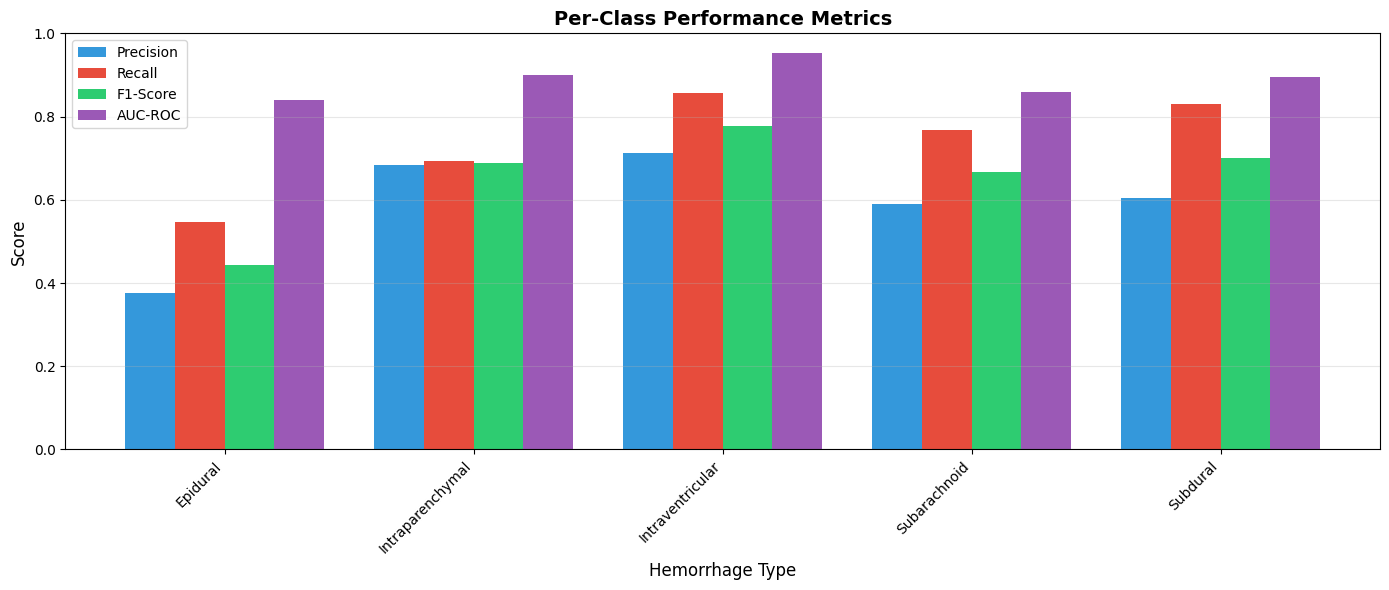

In [10]:
# Create bar chart of per-class metrics
class_names_plot = ['Epidural', 'Intraparenchymal', 'Intraventricular', 'Subarachnoid', 'Subdural']
class_names_key = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']

# Extract metrics
precisions = [test_metrics[f'precision_{name}'] for name in class_names_key]
recalls = [test_metrics[f'recall_{name}'] for name in class_names_key]
f1_scores = [test_metrics[f'f1_{name}'] for name in class_names_key]
aucs = [test_metrics.get(f'auc_roc_{name}', 0) for name in class_names_key]

# Plot
x = np.arange(len(class_names_plot))
width = 0.2

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x - 1.5*width, precisions, width, label='Precision', color='#3498db')
ax.bar(x - 0.5*width, recalls, width, label='Recall', color='#e74c3c')
ax.bar(x + 0.5*width, f1_scores, width, label='F1-Score', color='#2ecc71')
ax.bar(x + 1.5*width, aucs, width, label='AUC-ROC', color='#9b59b6')

ax.set_xlabel('Hemorrhage Type', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names_plot, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('../checkpoints/per_class_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

# Log to W&B
if USE_WANDB:
    wandb.log({"per_class_metrics": wandb.Image(plt)})


In [12]:
# Save test metrics to JSON
results = {
    'model': config['model']['name'],
    'test_metrics': {k: float(v) if isinstance(v, (np.floating, float)) else v 
                     for k, v in test_metrics.items()},
    'config': config
}

results_path = Path('./checkpoints/test_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"✓ Results saved to {results_path}")

# Print summary
print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(f"\nOverall Performance:")
print(f"  AUC-ROC (Macro):      {test_metrics['auc_roc_macro']:.4f}")
print(f"  AUC-ROC (Weighted):   {test_metrics.get('auc_roc_weighted', 0):.4f}")
print(f"  F1-Score (Macro):     {test_metrics['f1_macro']:.4f}")
print(f"  Exact Match Accuracy: {test_metrics['accuracy_exact']:.4f}")
print(f"  Hamming Accuracy:     {test_metrics['accuracy_hamming']:.4f}")
print("\n" + "="*80 + "\n")

# Finish W&B run
if USE_WANDB:
    wandb.finish()
    print("✓ W&B run finished")


✓ Results saved to checkpoints/test_results.json

FINAL RESULTS SUMMARY

Overall Performance:
  AUC-ROC (Macro):      0.8886
  AUC-ROC (Weighted):   0.8956
  F1-Score (Macro):     0.6554
  Exact Match Accuracy: 0.5153
  Hamming Accuracy:     0.8550




test/accuracy_exact,▁
test/accuracy_hamming,▁
test/auc_roc_epidural,▁
test/auc_roc_intraparenchymal,▁
test/auc_roc_intraventricular,▁
test/auc_roc_macro,▁
test/auc_roc_micro,▁
test/auc_roc_subarachnoid,▁
test/auc_roc_subdural,▁
test/auc_roc_weighted,▁
+27,...


✓ W&B run finished
